imports

In [28]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import json

Helper and preprocessing functions

In [58]:
def tf_scale_imgs(imgs, scale_factor):
    return imgs * scale_factor + 0.5 * (1 - scale_factor) * tf.ones(imgs.shape)


def tf_scale_labels(labels, scale_factor):
    return labels * scale_factor + 0.5 * (1 - scale_factor) * tf.ones(labels.shape)


def tf_f_inv(x, act_fn):
    """ (activation_size, batch_size) """
    if act_fn == "LINEAR":
        m = x
    elif act_fn == "TANH":
        num = tf.ones_like(x) + x
        div = tf.ones_like(x) - x + 1e-7
        m = 0.5 * tf.math.log(num / div)
    elif act_fn == "LOGSIG":
        div = tf.ones_like(x) - x + 1e-7
        m = tf.math.log((x / div) + 1e-7)
    else:
        raise ValueError(f"{act_fn} not supported")
    return m


def img_preproc(x, y, dtype=tf.float32): # add: tf.image.resize(image, [28,28])
  """Cast input image to a certain tf dtype and normalize them between 0 and 1."""
  x = tf.cast(x, dtype) / 255.
  #x = tf_scale_imgs(x, cf.img_scale)
  #y = tf_scale_labels(y, cf.label_scale)
  #x = tf_f_inv(x, "TANH")
  #y = tf.one_hot(y, depth=10)
  return x, y


def flatten(x, y):
  #flattens a video image series (or batch of images) to (n_batch, n_steps, 1) d.
  shape = tf.shape(x)
  if len(shape) == 5: # hack, determining if it's a video or not
    x = tf.reshape(x, [shape[0], shape[1], -1])
  elif len(shape) == 4:
    x = tf.reshape(x, [shape[0], -1])
  return x, y

def augment_images(batch_images, batch_labels):
    """
    Applies data augmentation on a batch of images without TensorFlow Addons.
    
    Parameters:
    batch_images: Tensor of shape (n_batch, 96, 96, 3)
    
    Returns:
    Augmented batch of images.
    """
    # Random horizontal flip
    augmented_images = tf.image.random_flip_left_right(batch_images)
    
    # Random brightness adjustment
    augmented_images = tf.image.random_brightness(augmented_images, max_delta=0.1)
    
    # Random contrast adjustment
    augmented_images = tf.image.random_contrast(augmented_images, lower=0.9, upper=1.1)
    
    # Random saturation adjustment
    augmented_images = tf.image.random_saturation(augmented_images, lower=0.9, upper=1.1)
    
    # Random hue adjustment
    augmented_images = tf.image.random_hue(augmented_images, max_delta=0.05)
    
    # Clipping to ensure pixel values are valid after transformations
    augmented_images = tf.clip_by_value(augmented_images, 0.0, 1.0)
    
    return augmented_images, batch_labels



Load the data

In [59]:
# Create a leading and trailing dataset with tensorflow

img_dir_lead = '/Users/denisekittelmann/Documents/Python/BiMoL/data/Leading/'
img_dir_trail = '/Users/denisekittelmann/Documents/Python/BiMoL/data/Trailing/'
img_dir_test_lead = '/Users/denisekittelmann/Documents/Python/BiMoL/data/Test/Test_Leading/'
img_dir_test_trail = '/Users/denisekittelmann/Documents/Python/BiMoL/data/Test/Test_Trailing/'
class_names_L = ['barn', 'beach', 'cave', 'library', 'restaurant']
class_names_T = ['castle', 'Church', 'conference_room', 'forest'] # changed the order 
batch_size = None # adjust if needed, e.g., 32
image_size = (28,28)
validation_split = 0.1
seed = 123

In [ ]:
# Create a leading and trailing dataset with tensorflow

img_dir_lead = '/scratch/guetlid95/datasets/mcdermott_2024/Stimuli_2/Leading/'
img_dir_trail = '/scratch/guetlid95/datasets/mcdermott_2024/Stimuli_2/Trailing/' 
img_dir_test_lead = '/scratch/guetlid95/datasets/mcdermott_2024/Stimuli_2/Test/Test_Leading/' 
img_dir_test_trail = '/scratch/guetlid95/datasets/mcdermott_2024/Stimuli_2/Test/Test_Trailing/' 
class_names_L = ['barn', 'beach', 'cave', 'library', 'restaurant']
class_names_T = ['castle', 'Church', 'conference_room', 'forest'] # changed the order 
batch_size = 32
image_size = (28,28)
validation_split = 0.1
seed = 123

In [60]:
# Create a dict that assigns the correct labels for each leading-trailing img pair

"""
L1 = barn = label 0 
L2 = beach = label 1
L3 = library = label 3
L4 = restaurant = label 4 
L5 = cave = label 2

T6 = Church = label 1   
T7 = conference room = label 2
T8 = castle = label 0   
T9 = forest = label 3

MAPPING:

L1 -> T6 = 0.75 -> (0,1) 
L1 -> T7 = 0.25 -> (0,2)
L1 -> T8 = 0 -> (0,0)
L1 -> T9 = 0 -> (0,3)

L2 -> T6 = 0.75 -> (1,1) 
L2 -> T7 = 0.25 -> (1,2)
L2 -> T8 = 0 -> (1,0)
L2 -> T9 = 0 -> (1,3)

L3 -> T6 = 0 -> (3,1) 
L3 -> T7 = 0 -> (3,2)
L3 -> T8 = 0.5 -> (3,0)
L3 -> T9 = 0.5 -> (3,3)

L4 -> T6 = 0.25 -> (4,1) 
L4 -> T7 = 0.75 -> (4,2)
L4 -> T8 = 0 -> (4,0)
L4 -> T9 = 0 -> (4,3)

L5 -> T6 = 0.25 -> (2,1) 
L5 -> T7 = 0.75 -> (2,2)
L5 -> T8 = 0 -> (2,0)
L5 -> T9 = 0 -> (2,3)

"""


label_dict = {
    (0, 1): 0.0,
    (0, 2): 0.75,
    (0, 0): 0.25,
    (0, 3): 0.25,
    
    (1, 1): 0.0,
    (1, 2): 0.75,
    (1, 0): 0.25,
    (1, 3): 0.25,
    
    (3, 1): 0.75,
    (3, 2): 0.75,
    (3, 0): 0.50,
    (3, 3): 0.50,
    
    (4, 1): 0.75,
    (4, 2): 0.0,
    (4, 0): 0.25,
    (4, 3): 0.25,
    
    (2, 1): 0.75, 
    (2, 2): 0.0,
    (2, 0): 0.25,
    (2, 3): 0.25
}



In [61]:
# Generate image pairs 
def img_sequence(img_t1, img_t2, label_t1, label_t2, label_dict): 
    """This function stacks two images to construct an image pair and assigns a single label based on the label dictionary."""
    
    img_t1 = tf.cast(img_t1, dtype=tf.float32)
    img_t2 = tf.cast(img_t2, dtype=tf.float32)
    
    x = tf.concat([img_t1, img_t2], axis=0) 

    key_t1 = int(label_t1.numpy())
    key_t2 = int(label_t2.numpy())
    
    if (key_t1, key_t2) in label_dict:
        label = label_dict[(key_t1, key_t2)]
        #print(f"Label value found: {label}")
    else:
        print(f"Label pair {(key_t1, key_t2)} not found.")

    y = tf.cast(tf.random.uniform([]) < label, tf.float32)
    y = tf.expand_dims(y, axis=0)  
    
    return x,y


In [62]:
def generate_dataset(img_dirt1, img_dirt2, class_namest1, class_namest2, label_dict, image_size = None, seed = None, shuffle=False):       
    
    
    data_t1 = tf.keras.preprocessing.image_dataset_from_directory(
        img_dirt1, 
        label_mode = 'int',
        class_names= class_namest1,
        batch_size = None,
        color_mode = 'rgb',
        image_size = image_size, 
        #shuffle = True, 
        seed = seed
        )

    data_t2 = tf.keras.preprocessing.image_dataset_from_directory(
        img_dirt2, 
        label_mode = 'int',
        class_names= class_namest2,
        batch_size = None,
        color_mode = 'rgb', 
        image_size = image_size, 
        #shuffle = True, 
        seed = seed
    )
    
    if shuffle:
        data_t1.shuffle(99999)
        data_t2.shuffle(99999)
    
    # iterate through shuffled leading and trailing datasets
    leading = iter(data_t1)
    trailing = iter(data_t2) 
              
    while True:
        try:
            # Retrieve single samples
            img_t1, label_t1 = next(leading)
            img_t2, label_t2 = next(trailing)

            # Generate x, y pairs for single samples
            x, y = img_sequence(img_t1, img_t2, label_t1, label_t2, label_dict)
            yield x, y
            
        except StopIteration:
            # Break the loop if no more samples
            break

     

In [63]:
from collections import Counter

def check_transition_balance(dataset):
    transition_counts = Counter()
    
    # Use as_numpy_iterator to extract data from the dataset
    for image, label in dataset.as_numpy_iterator():
        # Convert label to a scalar value if it's in a numpy array form
        transition_counts[label[0]] += 1  # Assuming label is a scalar or one-element array
    
    print("Transition frequencies:")
    for transition, count in transition_counts.items():
        print(f"Transition {transition}: {count} occurrences")


In [74]:
# Build the validation dataset 

seed = 123

val_dataset = tf.data.Dataset.from_generator(
    lambda: generate_dataset(img_dir_test_lead, img_dir_test_trail, class_names_L, class_names_T, label_dict, image_size = (28,28), seed = seed),
    output_signature=(
        tf.TensorSpec(shape=(56, 28, 3), dtype=tf.float32),  # shape of x 
        tf.TensorSpec(shape=(1), dtype=tf.float32)  # shape of y 
    )
) 

print(val_dataset)

<_FlatMapDataset element_spec=(TensorSpec(shape=(56, 28, 3), dtype=tf.float32, name=None), TensorSpec(shape=(1,), dtype=tf.float32, name=None))>


In [ ]:
# define the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=6, activation="sigmoid"), # 
    tf.keras.layers.Dense(units=4, activation="sigmoid"),  # Second layer 2
    tf.keras.layers.Dense(units=1, activation="sigmoid")  # Output layer
])

model.build([None,4704]) 
model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-5, weight_decay=1e-2),
              metrics=["accuracy"],
              loss="BinaryCrossentropy",  # "CategoricalCrossentropy" "MeanSquaredError" 
              )

# save model before training
model.save('/Users/denisekittelmann/Documents/Python/BiMoL/results/bp_ann/final_model_bp_lr1e-7_untrained.keras') 

# evaluate accuracy and train model
loss, accuracy = model.evaluate(val_dataset.batch(512).map(img_preproc).map(flatten)) 
print(f"Accuracy before training: {accuracy}")


n_epochs = 1000

train_acc = []
val_acc = []
train_loss = []
val_loss = []
histories = []


for i in range(n_epochs): 
    
    resultspath = f'/Users/denisekittelmann/Documents/Python/BiMoL/results/bp_ann/model_checkpoint_{i:02d}_{{accuracy:.2f}}.keras'
    
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=resultspath,  
        monitor='accuracy',       
        save_best_only=False,      
        save_weights_only=False,   
        mode='max',                
        save_freq='epoch',         
        verbose=1                  
    )
    
    print(f"Epoch {i + 1}/{n_epochs}") 
    train_dataset = tf.data.Dataset.from_generator(
        lambda: generate_dataset(img_dir_lead, img_dir_trail, class_names_L, class_names_T, label_dict, image_size = (28,28), seed = i, shuffle =True), 
        output_signature=(
            tf.TensorSpec(shape=(56, 28, 3), dtype=tf.float32),  # shape of x 
            tf.TensorSpec(shape=(1), dtype=tf.float32)  # shape of y 
        )
    )  
    
    check_transition_balance(train_dataset)
    
    history = model.fit(train_dataset.shuffle(99999).batch(512).map(img_preproc).map(augment_images).map(flatten), 
            validation_data=val_dataset.batch(512).map(img_preproc).map(flatten),
            callbacks=[checkpoint_callback]) 

    
    train_acc.extend(history.history['accuracy'])
    val_acc.extend(history.history['val_accuracy'])
    train_loss.extend(history.history['loss'])
    val_loss.extend(history.history['val_loss'])
    
    epoch_history = {
        "epoch": i + 1,
        "history": history.history
    }
    
    histories.append(epoch_history)

# After the loop, save the aggregated history to a single JSON file
    with open('/Users/denisekittelmann/Documents/Python/BiMoL/results/bp_ann/epochs_history.json', 'w') as f:
        json.dump(histories, f)


loss, accuracy = model.evaluate(val_dataset.batch(512).map(img_preproc).map(flatten)) 
print(f"Accuracy after training: {accuracy}")

model.save('/Users/denisekittelmann/Documents/Python/BiMoL/results/bp_ann/final_model_bp_lr1e-7_trained.keras') 

Found 180 files belonging to 5 classes.
Found 180 files belonging to 4 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 897ms/step - accuracy: 0.6222 - loss: 0.6853
Accuracy before training: 0.6222222447395325
Epoch 1/1000
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.
Transition frequencies:
Transition 0.0: 1110 occurrences
Transition 1.0: 506 occurrences
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.
      3/Unknown 4s 40ms/step - accuracy: 0.6525 - loss: 0.6828Found 180 files belonging to 5 classes.
Found 180 files belonging to 4 classes.

Epoch 1: saving model to /Users/denisekittelmann/Documents/Python/BiMoL/results/bp_ann/model_checkpoint_reduced_00_0.66.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 217ms/step - accuracy: 0.6551 - loss: 0.6825 - val_accuracy: 0.6611 - val_loss: 0.6801
Epoch 2/1000
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.
Transition frequencies:
Transition 1.0: 556 occurrences
T

: 

In [57]:
for i in range(2): 
    
    resultspath = f'/Users/denisekittelmann/Documents/Python/BiMoL/results/bp_ann/model_checkpoint_reduced_{i:02d}_{{accuracy:.2f}}.keras'
    print(resultspath)

/Users/denisekittelmann/Documents/Python/BiMoL/results/bp_ann/model_checkpoint_reduced_00_{accuracy:.2f}.keras
/Users/denisekittelmann/Documents/Python/BiMoL/results/bp_ann/model_checkpoint_reduced_01_{accuracy:.2f}.keras


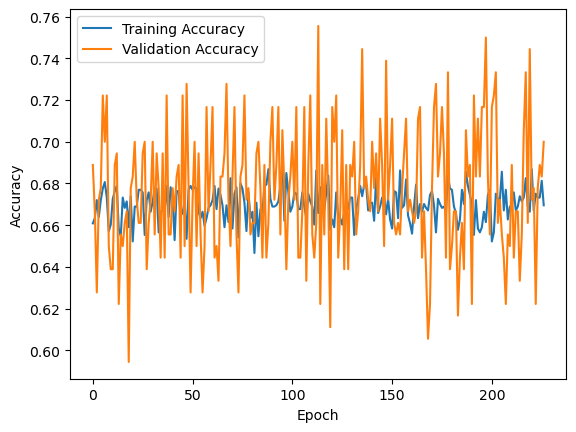

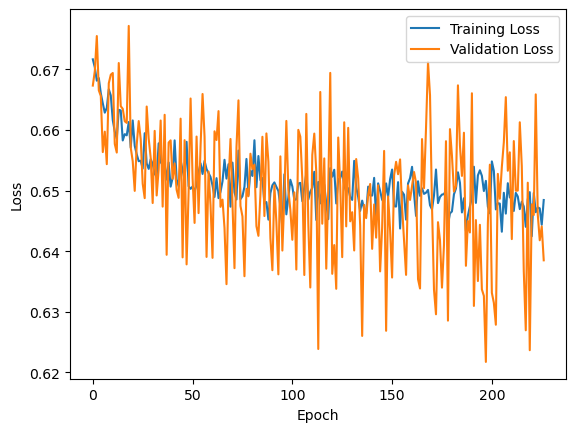

In [11]:
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

train the network

In [15]:
# define the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=6, activation="sigmoid"), # 
    tf.keras.layers.Dense(units=4, activation="sigmoid"),  # Second layer 2
    tf.keras.layers.Dense(units=1, activation="sigmoid")  # Output layer
])

model.build([None,4704]) 
model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-7, weight_decay=1e-2),
              metrics=["accuracy"],
              loss="BinaryCrossentropy",  # "CategoricalCrossentropy" "MeanSquaredError" 
              )

# save model before training
model.save('/Users/denisekittelmann/Documents/Python/BiMoL/results/bp_ann/final_model_bp_lr1e-7_untrained.keras') 

# evaluate accuracy and train model
loss, accuracy = model.evaluate(val_dataset.batch(512).map(img_preproc).map(flatten)) 
print(f"Accuracy before training: {accuracy}")


n_epochs = 1000

train_acc = []
val_acc = []
train_loss = []
val_loss = []


for i in range(n_epochs): 
    
    print(f"Epoch {i + 1}/{n_epochs}") 
    train_dataset = tf.data.Dataset.from_generator(
        lambda: generate_dataset(img_dir_lead, img_dir_trail, class_names_L, class_names_T, label_dict, image_size = (28,28), seed = i, shuffle =True), 
        output_signature=(
            tf.TensorSpec(shape=(56, 28, 3), dtype=tf.float32),  # shape of x 
            tf.TensorSpec(shape=(1), dtype=tf.float32)  # shape of y 
        )
    )  
    
    check_transition_balance(train_dataset)
    
    history = model.fit(train_dataset.shuffle(99999).batch(512).map(img_preproc).map(augment_images).map(flatten), 
            validation_data=val_dataset.batch(512).map(img_preproc).map(flatten),
            callbacks=[checkpoint_callback]) 
    
    train_acc.extend(history.history['accuracy'])
    val_acc.extend(history.history['val_accuracy'])
    train_loss.extend(history.history['loss'])
    val_loss.extend(history.history['val_loss'])

loss, accuracy = model.evaluate(val_dataset.batch(512).map(img_preproc).map(flatten)) 
print(f"Accuracy after training: {accuracy}")

model.save('/Users/denisekittelmann/Documents/Python/BiMoL/results/bp_ann/final_model_bp_lr1e-7_trained.keras') 

Found 180 files belonging to 5 classes.
Found 180 files belonging to 4 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 809ms/step - accuracy: 0.6833 - loss: 0.6305
Accuracy before training: 0.6833333373069763
Epoch 1/1000
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.
Transition frequencies:
Transition 0.0: 1097 occurrences
Transition 1.0: 519 occurrences
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.
      3/Unknown 4s 36ms/step - accuracy: 0.6630 - loss: 0.6485

2024-10-30 17:20:13.020203: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Found 180 files belonging to 5 classes.
Found 180 files belonging to 4 classes.

Epoch 1: saving model to /Users/denisekittelmann/Documents/Python/BiMoL/results/bp_ann/model_checkpoint_reduced_01_0.66.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 189ms/step - accuracy: 0.6631 - loss: 0.6483 - val_accuracy: 0.6667 - val_loss: 0.6456
Epoch 2/1000
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.
Transition frequencies:
Transition 0.0: 1081 occurrences
Transition 1.0: 535 occurrences
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.
      3/Unknown 3s 41ms/step - accuracy: 0.6887 - loss: 0.6246Found 180 files belonging to 5 classes.
Found 180 files belonging to 4 classes.

Epoch 1: saving model to /Users/denisekittelmann/Documents/Python/BiMoL/results/bp_ann/model_checkpoint_reduced_01_0.69.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 185ms/step - accuracy: 0.6875 - loss: 0.6258 - val_accuracy: 0.6611 - val_loss: 0.6498
Epoch 3/1000
Found 1616 file

2024-10-30 17:20:31.172420: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Transition frequencies:
Transition 1.0: 540 occurrences
Transition 0.0: 1076 occurrences
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.
      3/Unknown 3s 40ms/step - accuracy: 0.6557 - loss: 0.6562Found 180 files belonging to 5 classes.
Found 180 files belonging to 4 classes.

Epoch 1: saving model to /Users/denisekittelmann/Documents/Python/BiMoL/results/bp_ann/model_checkpoint_reduced_01_0.66.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 191ms/step - accuracy: 0.6588 - loss: 0.6533 - val_accuracy: 0.6722 - val_loss: 0.6411
Epoch 5/1000
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.
Transition frequencies:
Transition 0.0: 1082 occurrences
Transition 1.0: 534 occurrences
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.
      3/Unknown 3s 41ms/step - accuracy: 0.6725 - loss: 0.6407Found 180 files belonging to 5 classes.
Found 180 files belonging to 4 classes.

Epoch 1: saving model to /Users/deni

2024-10-30 17:21:07.887370: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Found 180 files belonging to 5 classes.
Found 180 files belonging to 4 classes.

Epoch 1: saving model to /Users/denisekittelmann/Documents/Python/BiMoL/results/bp_ann/model_checkpoint_reduced_01_0.68.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 185ms/step - accuracy: 0.6802 - loss: 0.6325 - val_accuracy: 0.6556 - val_loss: 0.6553
Epoch 10/1000
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.
Transition frequencies:
Transition 1.0: 531 occurrences
Transition 0.0: 1085 occurrences
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.
      3/Unknown 3s 36ms/step - accuracy: 0.6750 - loss: 0.6362Found 180 files belonging to 5 classes.
Found 180 files belonging to 4 classes.

Epoch 1: saving model to /Users/denisekittelmann/Documents/Python/BiMoL/results/bp_ann/model_checkpoint_reduced_01_0.69.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 209ms/step - accuracy: 0.6793 - loss: 0.6324 - val_accuracy: 0.6833 - val_loss: 0.6300
Epoch 11/1000
Found 1616 fi

2024-10-30 17:22:19.119987: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Transition frequencies:
Transition 1.0: 525 occurrences
Transition 0.0: 1091 occurrences
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.
      3/Unknown 3s 52ms/step - accuracy: 0.6850 - loss: 0.6277Found 180 files belonging to 5 classes.
Found 180 files belonging to 4 classes.

Epoch 1: saving model to /Users/denisekittelmann/Documents/Python/BiMoL/results/bp_ann/model_checkpoint_reduced_01_0.69.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 179ms/step - accuracy: 0.6850 - loss: 0.6279 - val_accuracy: 0.7000 - val_loss: 0.6143
Epoch 21/1000
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.
Transition frequencies:
Transition 0.0: 1074 occurrences
Transition 1.0: 542 occurrences
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.
      3/Unknown 3s 40ms/step - accuracy: 0.6673 - loss: 0.6455Found 180 files belonging to 5 classes.
Found 180 files belonging to 4 classes.

Epoch 1: saving model to /Users/den

2024-10-30 17:24:42.022492: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Found 180 files belonging to 5 classes.
Found 180 files belonging to 4 classes.

Epoch 1: saving model to /Users/denisekittelmann/Documents/Python/BiMoL/results/bp_ann/model_checkpoint_reduced_01_0.68.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 181ms/step - accuracy: 0.6855 - loss: 0.6279 - val_accuracy: 0.6278 - val_loss: 0.6831
Epoch 42/1000
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.
Transition frequencies:
Transition 1.0: 530 occurrences
Transition 0.0: 1086 occurrences
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.
      3/Unknown 3s 42ms/step - accuracy: 0.6858 - loss: 0.6274Found 180 files belonging to 5 classes.
Found 180 files belonging to 4 classes.

Epoch 1: saving model to /Users/denisekittelmann/Documents/Python/BiMoL/results/bp_ann/model_checkpoint_reduced_01_0.68.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 179ms/step - accuracy: 0.6815 - loss: 0.6313 - val_accuracy: 0.6611 - val_loss: 0.6507
Epoch 43/1000
Found 1616 fi

2024-10-30 17:29:27.337980: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Transition frequencies:
Transition 0.0: 1084 occurrences
Transition 1.0: 532 occurrences
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.
      3/Unknown 3s 40ms/step - accuracy: 0.6567 - loss: 0.6541Found 180 files belonging to 5 classes.
Found 180 files belonging to 4 classes.

Epoch 1: saving model to /Users/denisekittelmann/Documents/Python/BiMoL/results/bp_ann/model_checkpoint_reduced_01_0.66.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 178ms/step - accuracy: 0.6579 - loss: 0.6528 - val_accuracy: 0.6500 - val_loss: 0.6626
Epoch 85/1000
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.
Transition frequencies:
Transition 0.0: 1074 occurrences
Transition 1.0: 542 occurrences
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.
      3/Unknown 3s 39ms/step - accuracy: 0.6684 - loss: 0.6434Found 180 files belonging to 5 classes.
Found 180 files belonging to 4 classes.

Epoch 1: saving model to /Users/den

2024-10-30 17:39:04.712731: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Found 180 files belonging to 5 classes.
Found 180 files belonging to 4 classes.

Epoch 1: saving model to /Users/denisekittelmann/Documents/Python/BiMoL/results/bp_ann/model_checkpoint_reduced_01_0.66.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 188ms/step - accuracy: 0.6663 - loss: 0.6452 - val_accuracy: 0.7056 - val_loss: 0.6083
Epoch 170/1000
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.
Transition frequencies:
Transition 0.0: 1073 occurrences
Transition 1.0: 543 occurrences
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.
      3/Unknown 3s 42ms/step - accuracy: 0.6853 - loss: 0.6271Found 180 files belonging to 5 classes.
Found 180 files belonging to 4 classes.

Epoch 1: saving model to /Users/denisekittelmann/Documents/Python/BiMoL/results/bp_ann/model_checkpoint_reduced_01_0.68.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 183ms/step - accuracy: 0.6835 - loss: 0.6289 - val_accuracy: 0.6722 - val_loss: 0.6388
Epoch 171/1000
Found 1616 

2024-10-30 17:58:44.991053: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Transition frequencies:
Transition 1.0: 547 occurrences
Transition 0.0: 1069 occurrences
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.
      3/Unknown 3s 40ms/step - accuracy: 0.6711 - loss: 0.6401Found 180 files belonging to 5 classes.
Found 180 files belonging to 4 classes.

Epoch 1: saving model to /Users/denisekittelmann/Documents/Python/BiMoL/results/bp_ann/model_checkpoint_reduced_01_0.67.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 192ms/step - accuracy: 0.6695 - loss: 0.6417 - val_accuracy: 0.7000 - val_loss: 0.6116
Epoch 341/1000
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.
Transition frequencies:
Transition 1.0: 537 occurrences
Transition 0.0: 1079 occurrences
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.
      3/Unknown 4s 77ms/step - accuracy: 0.6815 - loss: 0.6303Found 180 files belonging to 5 classes.
Found 180 files belonging to 4 classes.

Epoch 1: saving model to /Users/de

2024-10-30 18:41:28.962161: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Found 180 files belonging to 5 classes.
Found 180 files belonging to 4 classes.

Epoch 1: saving model to /Users/denisekittelmann/Documents/Python/BiMoL/results/bp_ann/model_checkpoint_reduced_01_0.66.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 318ms/step - accuracy: 0.6664 - loss: 0.6420 - val_accuracy: 0.6556 - val_loss: 0.6546
Epoch 682/1000
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.
Transition frequencies:
Transition 0.0: 1094 occurrences
Transition 1.0: 522 occurrences
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.
      3/Unknown 5s 49ms/step - accuracy: 0.6693 - loss: 0.6405Found 180 files belonging to 5 classes.
Found 180 files belonging to 4 classes.

Epoch 1: saving model to /Users/denisekittelmann/Documents/Python/BiMoL/results/bp_ann/model_checkpoint_reduced_01_0.67.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 266ms/step - accuracy: 0.6701 - loss: 0.6396 - val_accuracy: 0.6333 - val_loss: 0.6730
Epoch 683/1000
Found 1616 

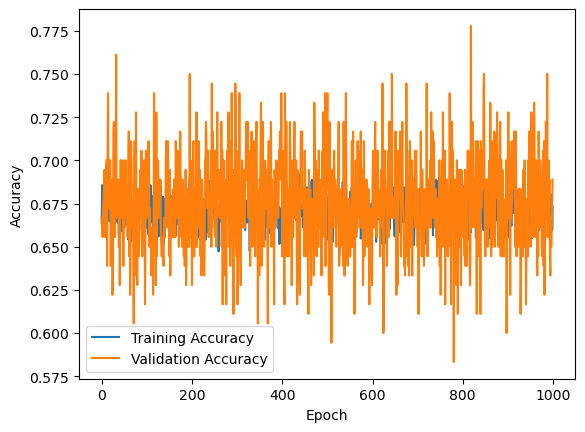

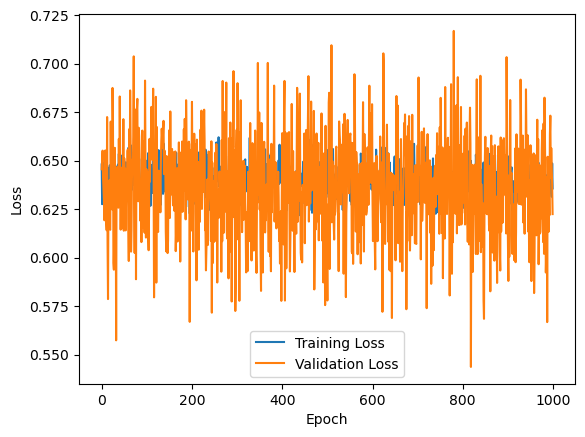

In [ ]:
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# lr e-7 + 

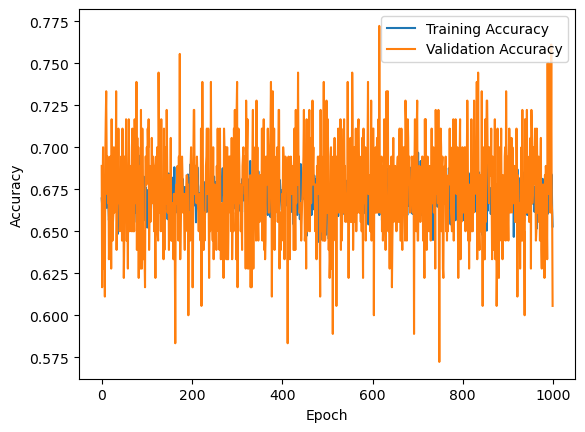

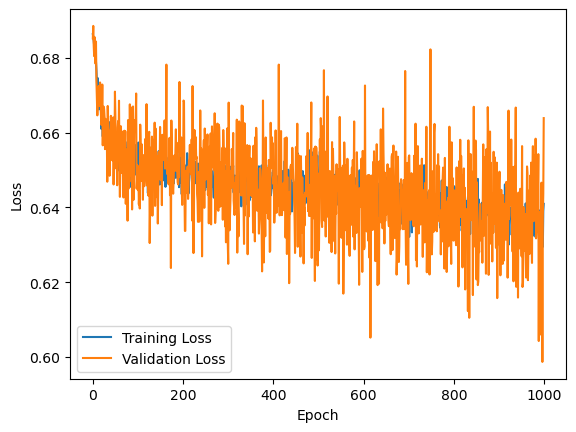

In [ ]:
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# lr e-7 + 

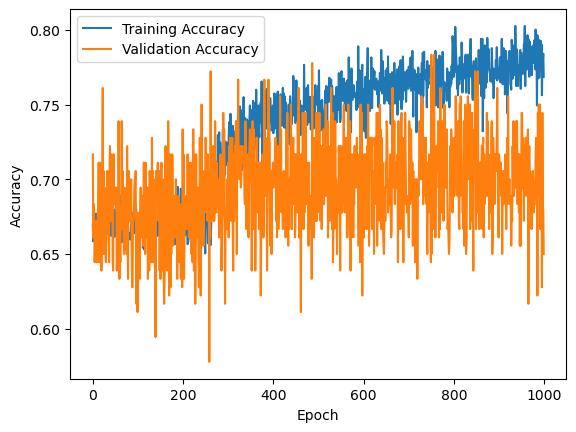

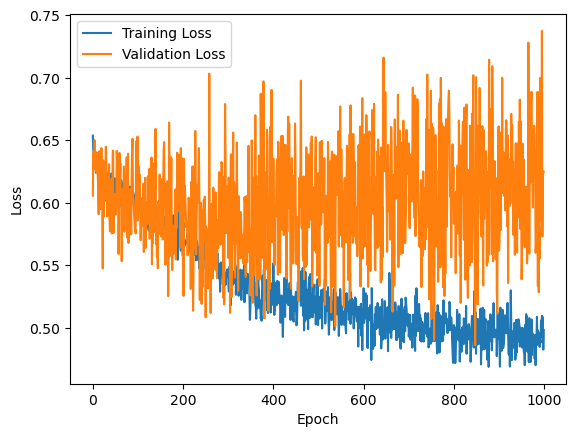

In [16]:
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# lr e-3 + 

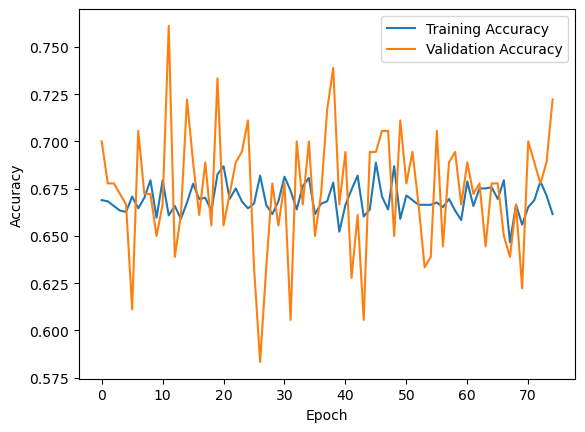

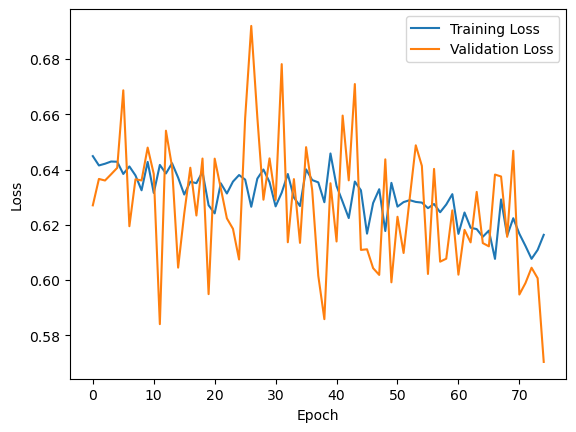

In [37]:
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# lr e-3 + 4,2,1

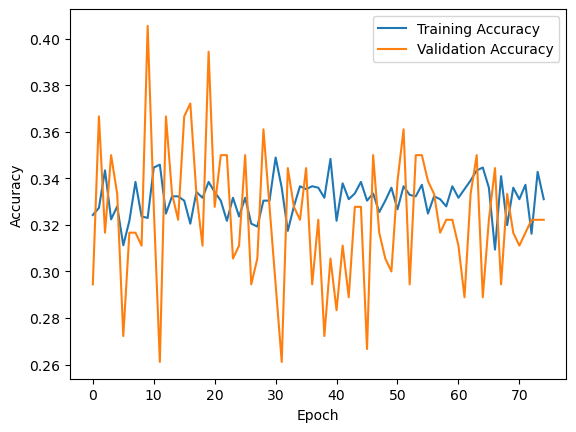

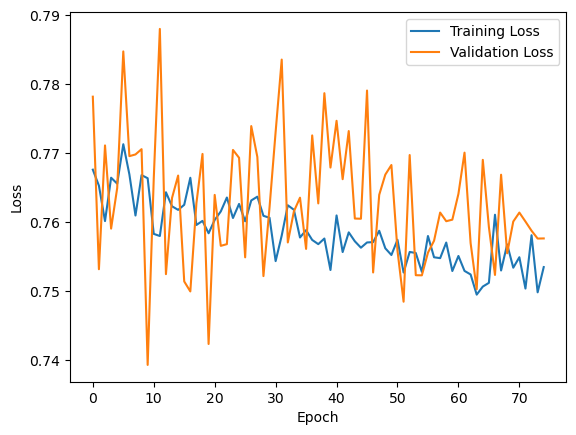

In [32]:
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# lr e-6

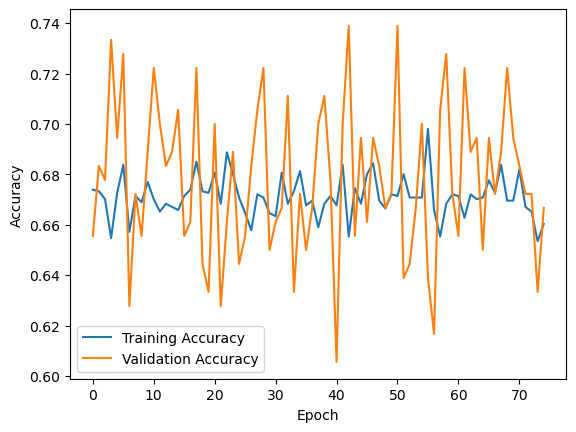

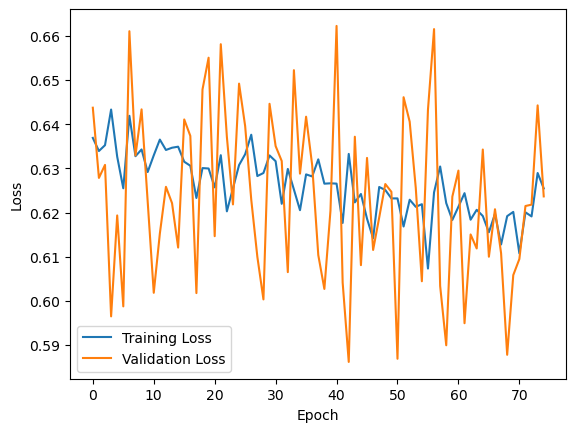

In [30]:
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# lr e-4

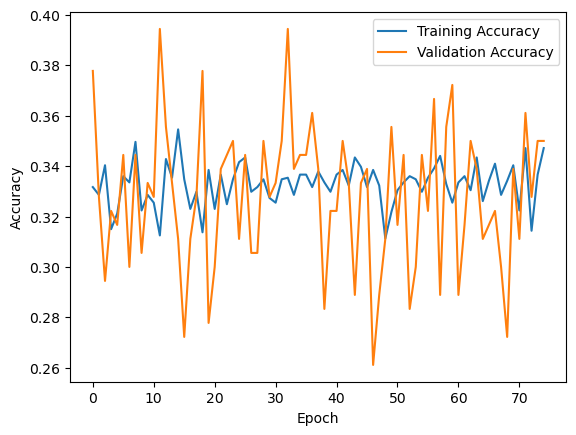

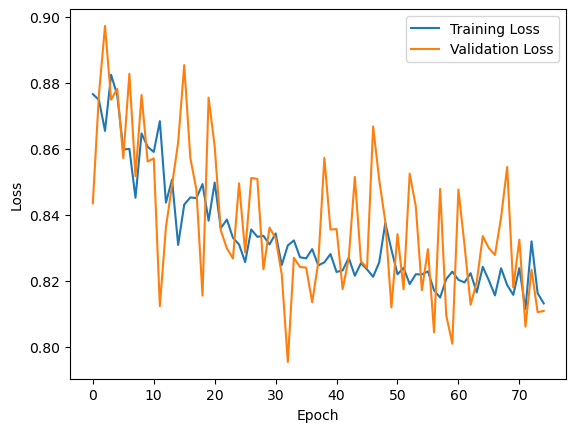

In [28]:
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# lr e-5

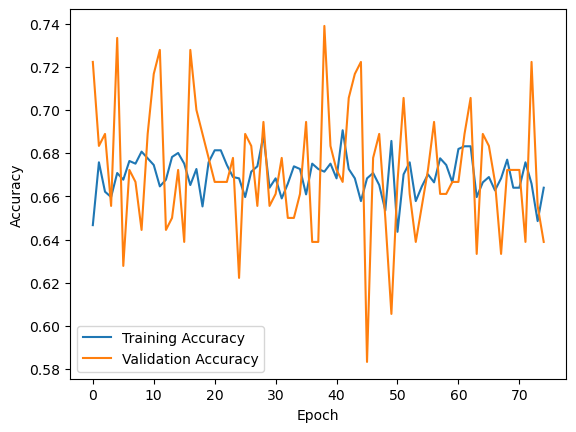

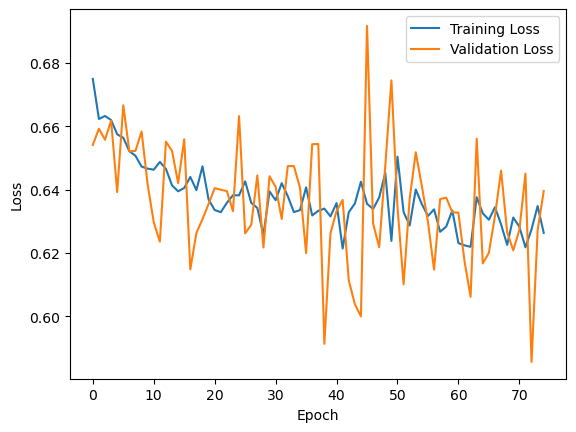

In [23]:
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# lr e-3

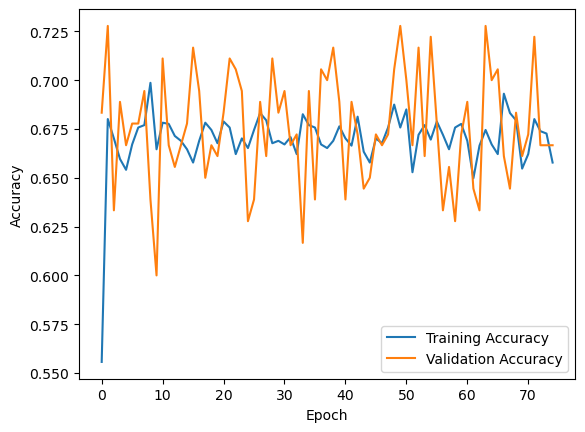

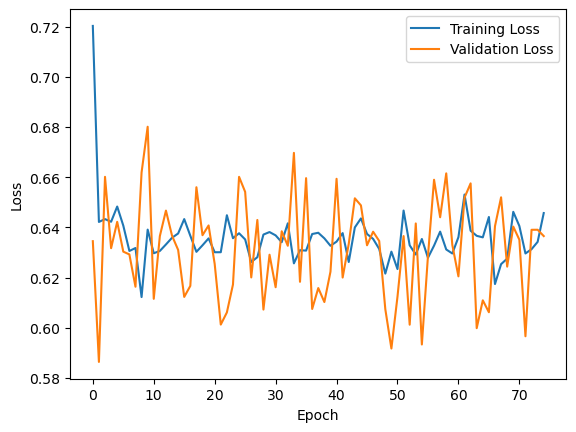

In [21]:
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# lr e-1

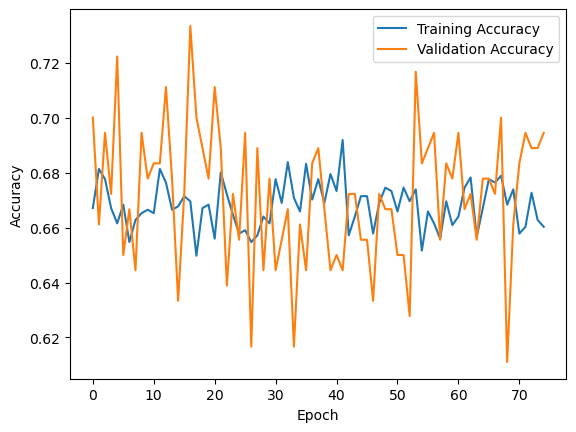

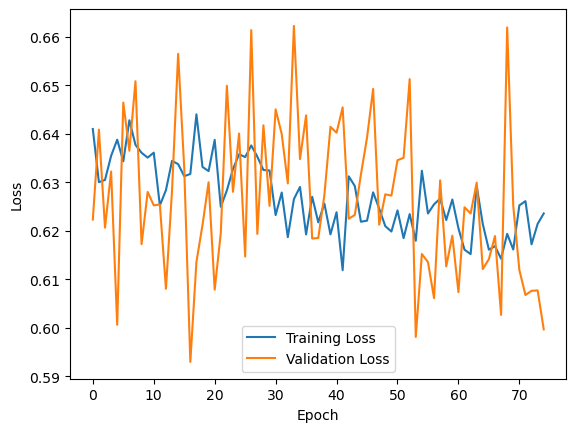

In [18]:
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# lr e-4

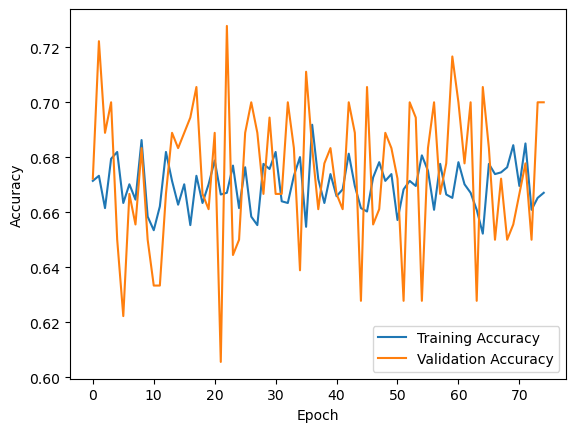

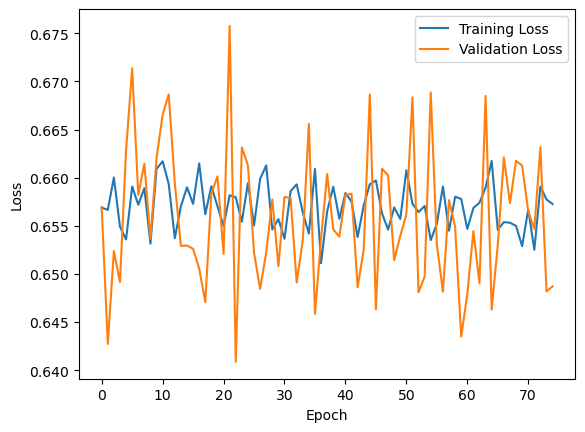

In [16]:
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# lr e-7

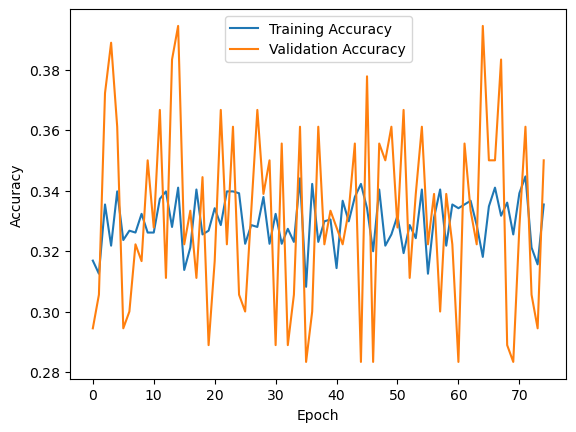

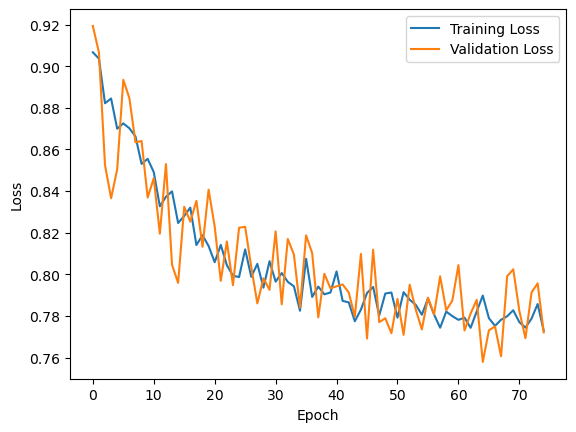

In [13]:
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# lr e-5

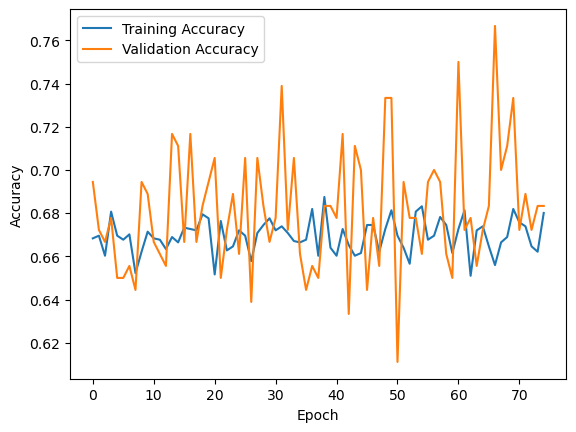

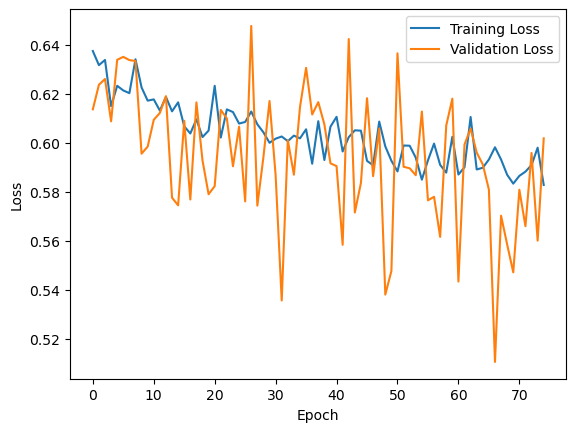

In [23]:
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# lr e-3